In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 버전 확인
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.8.0
2.8.0


In [3]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# # 이미지 augmentation
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# img_dir = "/content/drive/MyDrive/colab/data/raw_photo/augmentation_test"
# file_list = os.listdir(img_dir)
# print(file_list)

# for file in file_list:
#   datagen = ImageDataGenerator(
#         # rotation_range=40, # 이미지회전 / 우린 이거 쓰면 안될듯?
#         width_shift_range=0.2, # 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위
#         height_shift_range=0.2, # 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위
#         rescale=1./255, # 모델을 효과적으로 학습시키기에 너무 높다. 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환
#         # shear_range=0.2, # 임의 전단 변환 이건 모르겠네
#         zoom_range=0.2, # 임의 확대/축소 범위
#         horizontal_flip=True, # True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집는다.
#         fill_mode='nearest' #  이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식 
#         ) 
  
#   # img = load_img('/content/drive/MyDrive/colab/data/raw_photo/augmentation_test')  # PIL 이미지
#   # x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
#   # x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

#   # # 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
#   # # 지정된 `aug_img/` 폴더에 저장합니다.
  
#   # for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/colab/data/raw_photo/aug_img', save_prefix='front_normal', save_format='jpg'):
#   #     i += 1
#   #     if i > 10:
#   #         break  # 이미지 10장을 생성하고 마칩니다
#   img = load_img('/content/drive/MyDrive/colab/data/raw_photo/augmentation_test/front_normal_13147.jpg')  # PIL 이미지
#   x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
#   x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

#   # 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
#   # 지정된 `aug_img/` 폴더에 저장합니다.
#   i = 0
#   for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/colab/data/raw_photo/aug_img', save_prefix='front_normal', save_format='jpg'):
#       i += 1
#       if i > 10:
#           break  # 이미지 10장을 생성하고 마칩니다


In [4]:
# 구글드라이브 경로로 변경 완료
img_dir = "/content/drive/MyDrive/colab/data/raw_photo/self_dataset"
categories = ["Turtle", "Normal"]
np_classes = len(categories)

# 이미지 리사이징, 모델이랑 맞춰줘야함
image_w = 64 # 64
image_h = 64 # 64

file_list = os.listdir(img_dir)
position_list = []

for file in file_list:
    splitted_file_name = file.split("_")
    if splitted_file_name[1] == "normal": # 정상
        position_list.append(0)
    else: # 비정상(거북목)
        position_list.append(1)

pixel = image_h * image_w * 3 # 3은 RGB

X = [] # data
y = [] # position 

for position, file_name in zip(position_list, file_list):
    # print(file_name)
    # print(img_dir)
    img_file = img_dir+ "/" +file_name
    # print(img_file)

    img = Image.open(img_file)
    img = img.convert("RGB")
    # 이미지 픽셀값 리사이징
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    #Y는 0 아니면 1이니까 idx값으로 넣는다.
    X.append(data)
    y.append(position)

X = np.array(X) # 데이터 사진
Y = np.array(y) # x 데이터에 대한 라벨링

# random_state = 랜덤 변수를 줘서 테스트 데이터랑 트레인 데이터를 나눔, 이거 설정안하면 분류값이 달라짐(모델 성능 테스트할때 필요)
# stratify 데이터를 y 기준으로 균일하게 데이터 분류
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = True, stratify=Y, random_state=40)
##########################################################################################
# 이거 맞는지 모르겠다.
### X_train = 거북목이 아닌 학습데이터
### X_test = 거북목이 아닌 테스트용 데이터 validation data
### Y_train = 거북목인 학습 데이터
### Y_test = 거북목인 테스트용 데이터 validation data
##########################################################################################
# training 과정에서의 주 데이터는 train data이고 모델이 잘 학습이 되는지, 안되는지 'training' 과정에서 확인
# 검증하기 위해서 validation data를 사용
xy = (X_train, X_test, Y_train, Y_test)
np.save("./binary_image_data.npy", xy)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [5]:
print(len(X))
print(len(Y))
print(y.count(0)) 
print(y.count(1)) 
# 0 = 거북목이 아닌 정상 데이터 -> 400개 정도 구해야함 
# 1 = 거북목 + sleep, left, right 데이터 -> front만 남겨놓고 다시 데이터 구해야할듯..?

400
400
200
200


In [6]:
# 이제 훈련을 시작한다. 저장한 numpy 값을 가지고 와서 컨볼루션 망을 구축한다.

X_train, X_test, y_train, y_test = np.load('./binary_image_data.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train)) # 0, 1 / 같은 비율로 만들어야 오버피팅이 없다.
print(np.bincount(y_test))
print(X_train.shape[1:])

(320, 64, 64, 3)
320
[160 160]
[40 40]
(64, 64, 3)


In [7]:
image_w = 64
image_h = 64
# 이미지 정규화 (실수화)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


In [8]:
# CNN 3층 모델
model = Sequential()
## 입력층

model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
# padding : 경계 처리 방법을 정의합니다.

model.add(MaxPooling2D(pool_size=(2,2)))
# 지역적인 사소한 변화가 영향을 미치지 않도록 합니다.

## 중간층
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # 과적합 방지 

model.add(Flatten())
# 1차원으로 변경

## 출력층
model.add(Dense(256, activation="relu"))
# dense = 완전연결층(Fully Connected Layer)
model.add(Dropout(0.5))
# ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
model.add(Dense(1, activation="sigmoid"))

# 컴파일
# loss, optimizer 어떤게 정확도 더 높은지 테스트해야함
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model 저장
model_dir = './saved_model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
# patience는 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 것인지
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.012)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0

In [10]:
 history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test,Y_test), callbacks=[checkpoint, early_stopping])
#  history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=[checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.6031
Epoch 1: val_loss improved from inf to 0.63778, saving model to ./saved_model
INFO:tensorflow:Assets written to: ./saved_model/assets
10/10 [==============================] - 6s 570ms/step - loss: 0.6848 - accuracy: 0.6031 - val_loss: 0.6378 - val_accuracy: 0.8125
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7469
Epoch 2: val_loss improved from 0.63778 to 0.48427, saving model to ./saved_model
INFO:tensorflow:Assets written to: ./saved_model/assets
10/10 [==============================] - 4s 403ms/step - loss: 0.5484 - accuracy: 0.7469 - val_loss: 0.4843 - val_accuracy: 0.8500
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.7625
Epoch 3: val_loss did not improve from 0.48427
10/10 [==============================] - 2s 182ms/step - loss: 0.4981 - accuracy: 0.7625 - val_loss: 0.4943 - val_accuracy: 0.7125
Epoch 

In [11]:
# print((model.evaluate(X_test, y_test))) // juhan
print("정확도 : %.4f " %(model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 0s 35ms/step - loss: 0.0874 - accuracy: 0.9625
정확도 : 0.9625 


In [12]:
print(y_train)

[0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0
 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1
 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1
 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0]


In [13]:
print(history.history)

{'loss': [0.6848375797271729, 0.5483813881874084, 0.49808400869369507, 0.43494081497192383, 0.31153222918510437, 0.19573894143104553, 0.1447497457265854, 0.11467690765857697, 0.11507691442966461, 0.0866074338555336, 0.049397170543670654, 0.035446397960186005, 0.029526028782129288, 0.0303410105407238, 0.02428804337978363, 0.018864301964640617, 0.012284917756915092], 'accuracy': [0.6031249761581421, 0.746874988079071, 0.762499988079071, 0.8187500238418579, 0.8843749761581421, 0.9437500238418579, 0.9624999761581421, 0.971875011920929, 0.9624999761581421, 0.9750000238418579, 0.9906250238418579, 0.9937499761581421, 0.9937499761581421, 0.987500011920929, 0.9937499761581421, 0.9937499761581421, 1.0], 'val_loss': [0.6377812027931213, 0.4842723309993744, 0.49429410696029663, 0.38132232427597046, 0.2751084864139557, 0.19164173305034637, 0.180000901222229, 0.15635719895362854, 0.1986507624387741, 0.15312467515468597, 0.1150655522942543, 0.12505386769771576, 0.09994123876094818, 0.0766592100262641

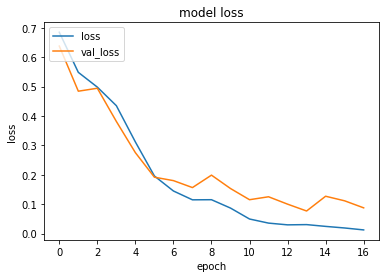

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

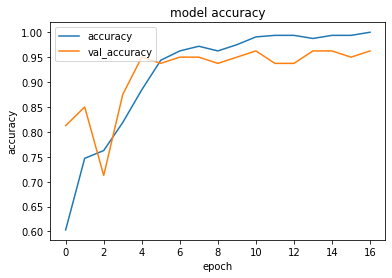

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

# validation = 검증
# loss 는 감소해야 좋다.
# accuracy는 올라가야함
# val_loss가 감소해야함 안하면 이 정확도는 믿으면 안된다. // 새로운 데이터가 들어와도 정확하지않다. 모델의 문제가 아니라 데이터 문제 사진을 더 구해야함.

In [16]:
from sklearn.metrics import r2_score, mean_squared_log_error
y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1) // argmax는 softmax , sigmoid는 범위 나눠서 해야함
y_pred = [0 if y < 0.5 else 1 for y in y_pred]
print(y_pred) # 

r2 = r2_score(y_test, y_pred)
#RMSLE = np.sqrt(mean_squared_log_error(test_Y, y_pred))

print("r_square score=", r2) # 1에 가까워야함

[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
r_square score= 0.85


In [17]:
# 혼동행렬

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(y_test, y_pred))

[[40  0]
 [ 3 37]]


In [18]:
# pca 처리
pcp_image = X
pcp_image_2d = pcp_image.reshape(-1, image_w*image_h*3) #  컬러일 경우

In [19]:
pcp_image_2d.shape

(400, 12288)

In [20]:
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


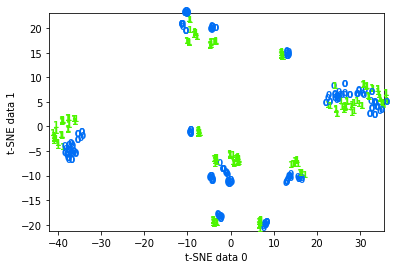

In [21]:
# 데이터 분포 확인

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

import matplotlib

import matplotlib.pyplot as plt


# digits = load_digits()


# t-SNE 모델 생성 및 학습

tsne = TSNE(random_state=0)

digits_tsne = tsne.fit_transform(pcp_image_2d)

colors = ['#006ef5', '#4ef500', '#f50031', '#4A2D4E', '#875525',

               '#A83683', '#4E655E', '#853541', '#3A3120', '#535D8E']

# 시각화

for i in range(len(pcp_image_2d)): # 0부터  digits.data까지 정수

    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(y[i]), # x, y , 그룹

             color=colors[y[i]], # 색상

             fontdict={'weight': 'bold', 'size':9}) # font

plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max()) # 최소, 최대

plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max()) # 최소, 최대

plt.xlabel('t-SNE data 0') # x축 이름

plt.ylabel('t-SNE data 1') # y축 이름

plt.show() # 그래프 출력

In [ ]:
# from PIL import Image
# import os, glob, numpy as np
# from keras.models import load_model

# import tensorflow as tf

# seed = 5
# tf.set_random_seed(seed)
# np.random.seed(seed)

# caltech_dir = './binary_img_data/img_test'


# image_w = 64
# image_h = 64

# pixels = image_h * image_w * 3

# X = []
# filenames = []
# files = glob.glob(caltech_dir+"/*/*.*")
# for i, f in enumerate(files):
#     img = Image.open(f)
#     img = img.convert("RGB")
#     img = img.resize((image_w, image_h))
#     data = np.asarray(img)

#     filenames.append(f)
#     X.append(data)


# X = np.array(X)
# X = X.astype(float) / 255
# model = load_model('./model/dog_cat_classify.model')

# prediction = model.predict(X)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# cnt = 0
# for i in prediction:
#     if i >= 0.5: print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는 거북목이 아닌거로 추정됩니다.") # 0이 거북목이 아닌거
#     else : print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는  거북목으로 추정됩니다.") # 1이 거북목인거
#     cnt += 1

In [ ]:
# # 모델 저장
# import pickle
# with open('/content/drive/MyDrive/colab/saved_model.pickle','wb') as fw:
#     pickle.dump(model, fw)

In [ ]:
# 모델 open
# import pickle 
# with open('/saved_model.pickle','rb') as f:
#     model = pickle.load(f)

In [ ]:
# import numpy
# print(numpy.__version__)
# print(skitlear)